In [1]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  dplyr,         # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  reshape2,         # restructure and aggregate data 
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)

# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.4.4"

In [2]:
# Load the data
bm <-"C:\\Users\\Mirela\\RStudioProjects\\Marketing\\datasets\\bank-marketing.csv"

if(!file.exists(bm)){tryCatch(bm)}

if(file.exists(bm)) bm_original <- read.csv(bm, header = TRUE, stringsAsFactors = FALSE, sep = ";")

head(bm_original)


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [4]:
# eliminate any duplicates that may exist in the dataset

bank <- bm_original%>%
  distinct(.keep_all = TRUE,education,balance,age)
# generate an id column for future use (joins etc)
bank$bank_id = seq.int(nrow(bank))

head(bank)
summary(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,bank_id
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,3
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,4
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,5
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,6


      age            job              marital           education        
 Min.   :18.00   Length:35732       Length:35732       Length:35732      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :40.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :41.23                                                           
 3rd Qu.:49.00                                                           
 Max.   :95.00                                                           
   default             balance         housing              loan          
 Length:35732       Min.   : -8019   Length:35732       Length:35732      
 Class :character   1st Qu.:   154   Class :character   Class :character  
 Mode  :character   Median :   584   Mode  :character   Mode  :character  
                    Mean   :  1549                                        
                    3rd Qu.:  1694                                        
                    Max.   :1021

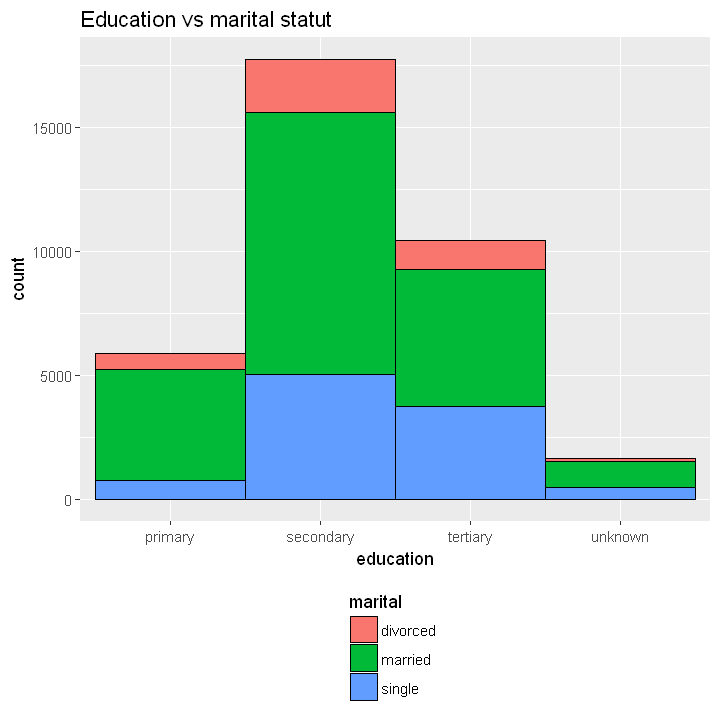

In [5]:
bank %>%
  ggplot(mapping = aes(education)) +
  geom_bar(aes(fill=marital), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Education vs marital statut")


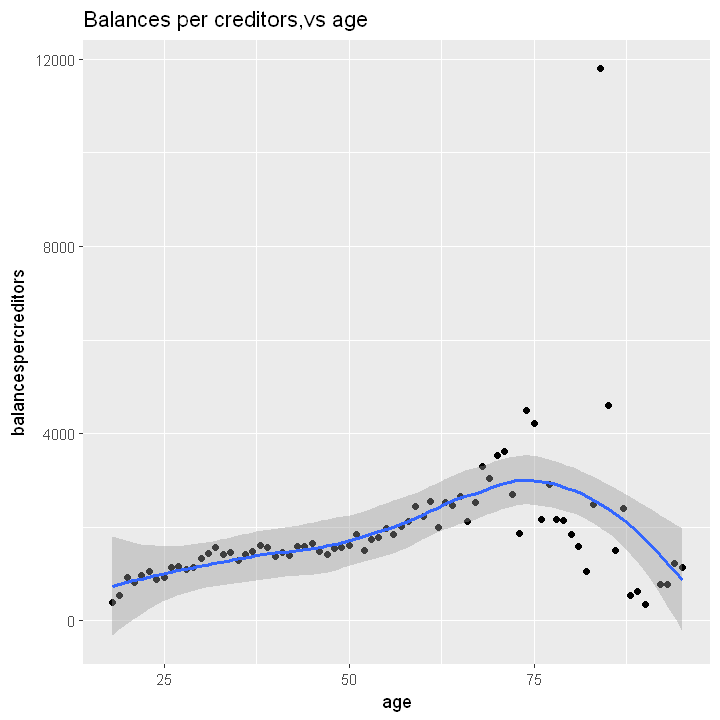

In [6]:
bank %>%
  dplyr::group_by(age = age) %>%
  dplyr::summarize(
    totalcreditors = n(),
    totalbalances = sum(balance),
    balancespercreditors = totalbalances / totalcreditors
  ) %>%
  ggplot(mapping = aes(x = age, y = balancespercreditors)) +
  geom_point() +
  geom_smooth(method = "loess") + ggtitle("Balances per creditors,vs age")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -8019     154     584    1549    1694  102127 

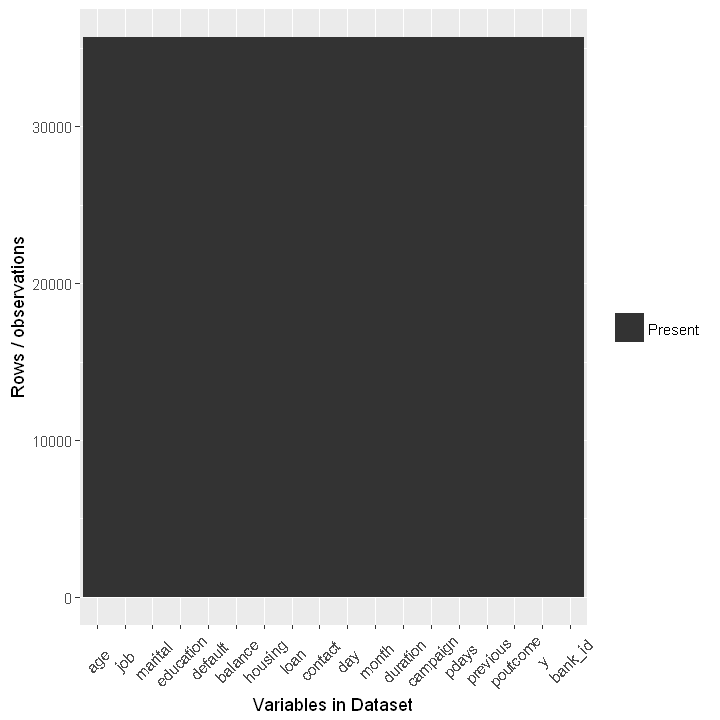

In [7]:
# what values is our dataset missing?

ggplot_missing <- function(x){
  
  x %>%
    is.na %>%
    melt %>%
    ggplot(mapping = aes(x = Var2,
                         y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5)) +
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

ggplot_missing(bank)

summary(bank$balance)

In [8]:
# creditors education type: Tertiary, Primary, Secondary,Unknown
bank$tertiary <- FALSE
bank$tertiary[bank$education == "tertiary"] <- TRUE

bank$primary <- FALSE
bank$primary[bank$education %like% "primary"] <- TRUE

bank$secondary <- FALSE
bank$secondary[bank$education %like% "secondary"] <- TRUE

bank$unknown <- FALSE
bank$unknown[bank$education %like% "unknown"] <- TRUE

head(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,no,1,TRUE,FALSE,FALSE,FALSE
44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,no,2,FALSE,FALSE,TRUE,FALSE
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,no,3,FALSE,FALSE,TRUE,FALSE
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,no,4,FALSE,FALSE,FALSE,TRUE
33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,no,5,FALSE,FALSE,FALSE,TRUE
35,management,married,tertiary,no,231,yes,no,unknown,5,...,1,-1,0,unknown,no,6,TRUE,FALSE,FALSE,FALSE


In [9]:
# not use unknown education creditors 

bank <- bank %>% dplyr::filter(unknown == FALSE)

bkmk_perf <- bank %>%
dplyr::mutate(
bal = (balance > 1000),
dtion = (duration < 150),
edumar = (education == "tertiary" & marital == "married"),
age = age,
job = job,
default = default,
housing = housing,
loan = loan,
contact = contact,
day = day,
month = month,
pdays = pdays,
previous = previous,
poutcome = poutcome,
y = y,
bank_id = bank_id,
tertiary = tertiary,
primary = primary,
secondary = secondary,
unknown = unknown) %>%
dplyr::select (bal, dtion, edumar, age, job, default, housing, loan, contact, day, month, pdays, previous, poutcome,y,bank_id,tertiary,primary,secondary,unknown)
head(bkmk_perf)

bal,dtion,edumar,age,job,default,housing,loan,contact,day,month,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
TRUE,FALSE,TRUE,58,management,no,yes,no,unknown,5,may,-1,0,unknown,no,1,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,44,technician,no,yes,no,unknown,5,may,-1,0,unknown,no,2,FALSE,FALSE,TRUE,FALSE
FALSE,TRUE,FALSE,33,entrepreneur,no,yes,yes,unknown,5,may,-1,0,unknown,no,3,FALSE,FALSE,TRUE,FALSE
FALSE,TRUE,TRUE,35,management,no,yes,no,unknown,5,may,-1,0,unknown,no,6,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,28,management,no,yes,yes,unknown,5,may,-1,0,unknown,no,7,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,42,entrepreneur,yes,yes,no,unknown,5,may,-1,0,unknown,no,8,TRUE,FALSE,FALSE,FALSE


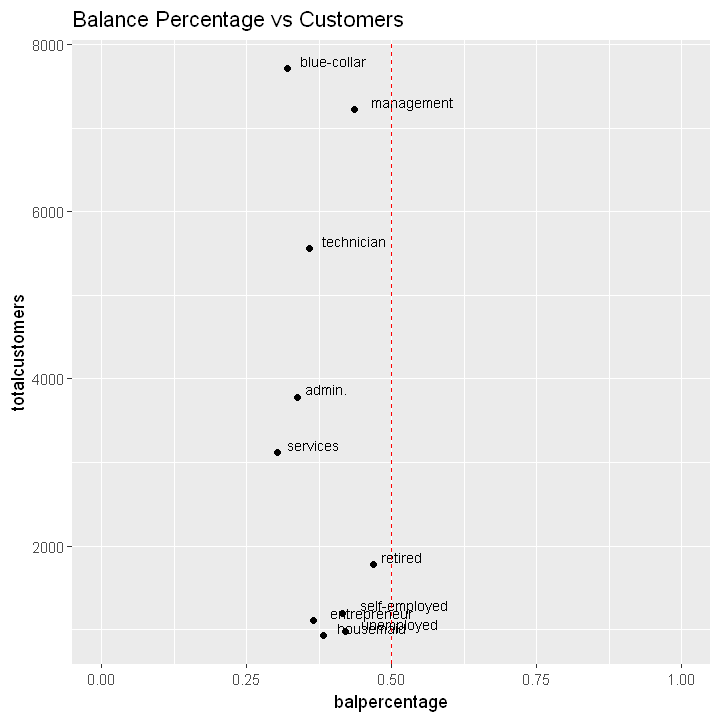

In [10]:
formula_balpercentage <- function(totalcustomers, balance) {
  return ((balance) / totalcustomers)
}

plot_balpercentage <- function(bkmk_perf, mincustomers) {
  bkmk_perf %>%
    group_by(job) %>%
    summarize(
      totalcustomers = n(),
      balance = length(bal[bal==TRUE]),
      balpercentage = formula_balpercentage(totalcustomers, balance)
    ) %>%
    filter(totalcustomers >= mincustomers ) %>%
    ggplot(mapping = aes(x = balpercentage, y = totalcustomers)) +
    geom_point(size = 1.5) + 
    geom_text(aes(label=job), hjust=-.2 , vjust=-.2, size=3) +
    geom_vline(xintercept = .5, linetype = 2, color = "red") +
    ggtitle("Balance Percentage vs Customers") +
    expand_limits(x = c(0,1))
} 

plot_balpercentage(bkmk_perf, 900)

In [11]:
# transform old job names into new ones( with CL).
jobNodeMappings <- matrix(c(
  "management","Management",
  "technician","Technician",
  "entrepreneur","Entrepreneur",
  "blue-collar","Blue-collar",
  "unknown","Unknown",
  "services","Services",
  "retired","Retired"
), ncol=2, byrow = TRUE)

for (i in 1:nrow(jobNodeMappings)) {
  bkmk_perf$job[bkmk_perf$job == jobNodeMappings[i,1]] <- jobNodeMappings[i,2]
  
  bank$job[bank$job == jobNodeMappings[i,1]] <- jobNodeMappings[i,2]
  
}

head(bkmk_perf)

bal,dtion,edumar,age,job,default,housing,loan,contact,day,month,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
TRUE,FALSE,TRUE,58,Management,no,yes,no,unknown,5,may,-1,0,unknown,no,1,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,44,Technician,no,yes,no,unknown,5,may,-1,0,unknown,no,2,FALSE,FALSE,TRUE,FALSE
FALSE,TRUE,FALSE,33,Entrepreneur,no,yes,yes,unknown,5,may,-1,0,unknown,no,3,FALSE,FALSE,TRUE,FALSE
FALSE,TRUE,TRUE,35,Management,no,yes,no,unknown,5,may,-1,0,unknown,no,6,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,28,Management,no,yes,yes,unknown,5,may,-1,0,unknown,no,7,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,42,Entrepreneur,yes,yes,no,unknown,5,may,-1,0,unknown,no,8,TRUE,FALSE,FALSE,FALSE


In [12]:
# what is the occurence frequency for martital statut?

maritalfreq <- bank %>%
  group_by(marital,job) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  mutate(
    maritaltext = paste(marital,"vs",job)
  ) %>%
  arrange(desc(freq)) 

head(maritalfreq, 15)

marital,job,n,freq,maritaltext
married,Blue-collar,5563,0.16321920,married vs Blue-collar
married,Management,4109,0.12055864,married vs Management
married,Technician,2942,0.08631869,married vs Technician
single,Management,2265,0.06645542,single vs Management
married,admin.,1956,0.05738931,married vs admin.
single,Technician,1928,0.05656779,single vs Technician
married,Services,1820,0.05339906,married vs Services
single,Blue-collar,1572,0.04612270,single vs Blue-collar
married,Retired,1339,0.03928645,married vs Retired
single,admin.,1259,0.03693924,single vs admin.


bal,n,freq
0,159,0.004665082
1,81,0.002376551
3,71,0.002083150
2,70,0.002053810
4,69,0.002024470
5,67,0.001965789
6,57,0.001672388
11,51,0.001496347
8,47,0.001378987
20,47,0.001378987


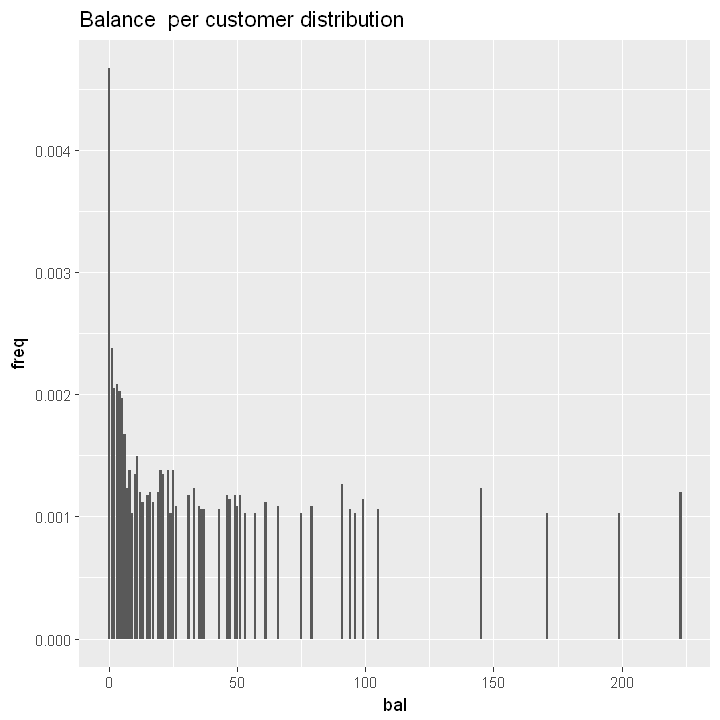

In [13]:
# distribution of balance per customer
balancefreq <- bank %>%
  group_by(bal= balance) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  arrange(desc(freq)) 

head(balancefreq, 25)

balancefreq %>%
  filter(freq >= 0.001) %>%
  ggplot(mapping = aes(x = bal, y = freq)) + geom_bar(stat = "identity") + ggtitle("Balance  per customer distribution")

ctage,n,freq
18,4,0.0001173606
19,21,0.0006161429
20,30,0.0008802042
21,62,0.0018190887
22,104,0.0030513746
23,168,0.0049291436
24,246,0.0072176745
25,418,0.0122641786
26,649,0.0190417510
27,711,0.0208608397


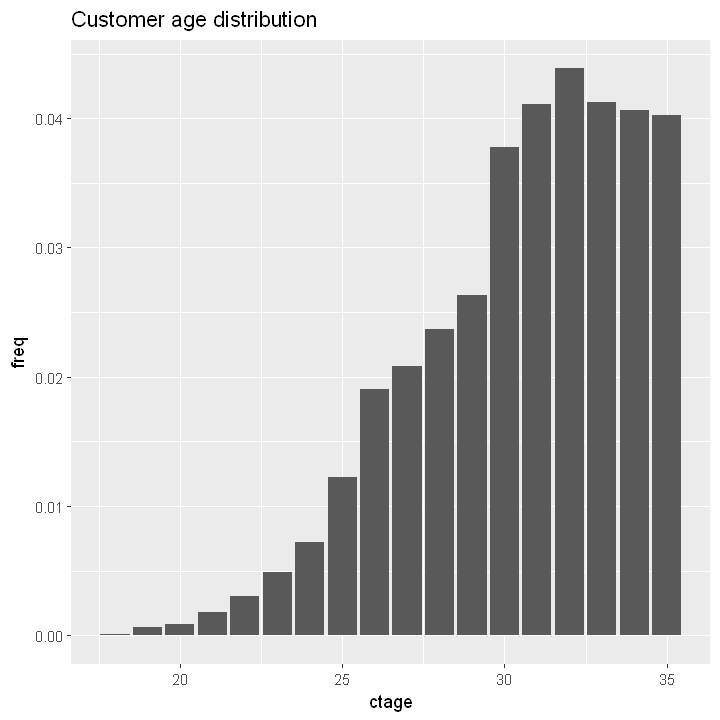

In [14]:
# distribution of customer age
agefreq <- bank %>%
  group_by(ctage = age) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  arrange(ctage) 

head(agefreq %>% filter(abs(ctage)<=35), 15)

agefreq %>%
  filter(abs(ctage)<=35) %>%
  ggplot(mapping = aes(x = ctage, y = freq)) + geom_bar(stat = "identity") + ggtitle("Customer age distribution")


In [15]:
# how many outliers do we have?
out <- bank %>% dplyr::filter(abs(age) > 60)
head(out)
paste(nrow(out), "outliers, or", (nrow(out)/nrow(bank)*100), "% of total.")

age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
61,Blue-collar,divorced,primary,no,1428,yes,no,unknown,5,...,2,-1,0,unknown,no,199,FALSE,TRUE,FALSE,FALSE
61,Retired,married,secondary,no,195,yes,yes,unknown,6,...,1,-1,0,unknown,no,558,FALSE,FALSE,TRUE,FALSE
61,Blue-collar,married,primary,no,734,yes,no,unknown,8,...,1,-1,0,unknown,no,1182,FALSE,TRUE,FALSE,FALSE
61,Retired,married,primary,no,1060,yes,no,unknown,13,...,1,-1,0,unknown,no,2326,FALSE,TRUE,FALSE,FALSE
61,Retired,married,secondary,no,4248,yes,no,unknown,14,...,1,-1,0,unknown,no,2852,FALSE,FALSE,TRUE,FALSE
61,Retired,married,secondary,no,280,yes,no,unknown,15,...,3,-1,0,unknown,no,3447,FALSE,FALSE,TRUE,FALSE


[1] "862 outliers, or 2.52912008919403 % of total."

In [16]:
# get rid of all the outliers by selecting the age to [20, 60]
bkmk_perf$age[bkmk_perf$age < 20] <- 20
bkmk_perf$age[bkmk_perf$age > 60] <- 60

In [17]:
# Let's calculate some lag features           
# we'll take three windows: last 10 customers, last 30 customers, last 50 customers.
# for each window we'll calculate some values

lagfn <- function(data, width) {
  return (rollapplyr(data, width = width + 1, FUN = sum, fill = NA, partial=TRUE) - data)
}

lagfn_per <- function(data, width) {
  return (lagfn(data, width) / width)
}

bank_features <- bkmk_perf %>%
  dplyr::arrange(job, age) %>%
  dplyr::group_by(job) %>%
  dplyr::mutate(
    last10customers_bal_per = lagfn_per(bal, 10),
    last30customers_bal_per = lagfn_per(bal, 30),
    last50customers_bal_per = lagfn_per(bal, 50),
    
    last10customers_dtion_per = lagfn_per(dtion, 10),
    last30customers_dtion_per = lagfn_per(dtion, 30),
    last50customers_dtion_per = lagfn_per(dtion, 50),
    
    last10customers_edumar_per = lagfn_per(edumar, 10),
    last30customers_edumar_per = lagfn_per(edumar, 30),
    last50customers_edumar_per = lagfn_per(edumar, 50),
    
    
  ) %>%
  dplyr::select (
    bank_id, age, job,
    bal, last10customers_bal_per, last30customers_bal_per, last50customers_bal_per,
    dtion, last10customers_dtion_per, last30customers_dtion_per, last50customers_dtion_per,
    edumar,last10customers_edumar_per, last30customers_edumar_per, last50customers_edumar_per
    
  ) %>%
  dplyr::ungroup()

head((bank_features %>% dplyr::filter(job == "technician" & age >= '20')), n = 35)
summary(bank_features)

bank_id,age,job,bal,last10customers_bal_per,last30customers_bal_per,last50customers_bal_per,dtion,last10customers_dtion_per,last30customers_dtion_per,last50customers_dtion_per,edumar,last10customers_edumar_per,last30customers_edumar_per,last50customers_edumar_per


    bank_id           age            job               bal         
 Min.   :    1   Min.   :20.00   Length:34083       Mode :logical  
 1st Qu.: 8964   1st Qu.:33.00   Class :character   FALSE:21466    
 Median :17926   Median :39.00   Mode  :character   TRUE :12617    
 Mean   :17874   Mean   :40.84                                     
 3rd Qu.:26746   3rd Qu.:49.00                                     
 Max.   :35732   Max.   :60.00                                     
 last10customers_bal_per last30customers_bal_per last50customers_bal_per
 Min.   :0.0000          Min.   :0.0000          Min.   :0.0000         
 1st Qu.:0.2000          1st Qu.:0.2667          1st Qu.:0.3000         
 Median :0.4000          Median :0.3667          Median :0.3600         
 Mean   :0.3691          Mean   :0.3673          Mean   :0.3656         
 3rd Qu.:0.5000          3rd Qu.:0.4333          3rd Qu.:0.4400         
 Max.   :1.0000          Max.   :0.8000          Max.   :0.7600         
   dtion     

In [18]:
# drop all non-interesting columns, and those which should not be supplied for new data 
bank_features <- bank_features %>%
  dplyr::select(-c(bank_id))

head(bank_features)
names(bank_features)

age,job,bal,last10customers_bal_per,last30customers_bal_per,last50customers_bal_per,dtion,last10customers_dtion_per,last30customers_dtion_per,last50customers_dtion_per,edumar,last10customers_edumar_per,last30customers_edumar_per,last50customers_edumar_per
20,admin.,FALSE,0,0,0,TRUE,0.0,0.00000000,0.00,FALSE,0,0,0
20,admin.,FALSE,0,0,0,TRUE,0.1,0.03333333,0.02,FALSE,0,0,0
21,admin.,FALSE,0,0,0,FALSE,0.2,0.06666667,0.04,FALSE,0,0,0
21,admin.,FALSE,0,0,0,TRUE,0.2,0.06666667,0.04,FALSE,0,0,0
21,admin.,FALSE,0,0,0,TRUE,0.3,0.10000000,0.06,FALSE,0,0,0
21,admin.,FALSE,0,0,0,FALSE,0.4,0.13333333,0.08,FALSE,0,0,0


[1] "age"                        "job"                       
 [3] "bal"                        "last10customers_bal_per"   
 [5] "last30customers_bal_per"    "last50customers_bal_per"   
 [7] "dtion"                      "last10customers_dtion_per" 
 [9] "last30customers_dtion_per"  "last50customers_dtion_per" 
[11] "edumar"                     "last10customers_edumar_per"
[13] "last30customers_edumar_per" "last50customers_edumar_per"